# Introducción

Necesitamos crear nuestro propio mundo con el que poder simular el comportamiento del robot de la manera más real posible.

Para ello vamos a realizar las siguientes tareas:

1- Crearemos un mundo en Gazebo que refleje el entorno de nuestro proyecto lo más fielmente que sea posible

2- Crearemos un paquete que contega todos los ficheros necesarios para simular el mundo en Gazebo

Tenéis todos los ficheros que necesitáis (menos los modelos de vuestro entorno) en [Recursos / Paquetes ROS2 / my_world.zip](https://poliformat.upv.es/x/4rWA0a)

# Creando un Mundo en Gazebo

Existen varios tutoriales que os pueden ayudar a crear vuestro mundo en Gazebo:

- [Página oficial de Gazebo](https://gazebosim.org/tutorials?cat=build_world)

- [Tutorial de nlamprian](https://nlamprian.me/blog/software/ros/2019/10/06/gazebo-virtual-worlds/)

Algunos aspectos a tener en cuenta:

- Para empezar a crear el mundo: lanzar Gazebo desde un terminal utilizando el comando sudo

```
sudo gazebo
```

- Grabar el mundo realizado utilizando la opción "Save As" y elegid la extensión sdf. 

Podéis utilizar otros programas para hacer este mundo siempre y cuando se cree un fichero sdf.

En este enlace tenéis información sobre este tipo de ficheros:


[Tutorial sdf](http://sdformat.org/tutorials?)


# Paquete Simulación 

Necesitamos crear un paquete que lance la simulación de nuestro entorno y añada el robot. Para ello seguiremos los pasos que se detallan a continuación:

1- Creamos un paquete con dependencias rclcpp, gazebo, gazebo_ros_pkg, geometry_msgs, nav_msgs, sensor_msgs, tf2 y turtlebot3_gazebo.

In [ ]:
cd turtlebot3_ws/src
ros2 pkg create --build-type ament_cmake my_world --dependencies rclcpp gazebo_ros_pkgs geometry_msgs nav_msgs sensor_msgs tf2 turtlebot3_gazebo

2- Incluimos los siguientes directorios:

- **launch**: donde se alojará el fichero de lanzamiento

- **models**: en el que incluiremos los modelos sdf creados. Crear dos subirectorios dentro de models porque vamos a tener que incluir el modelo del entorno del proyecto y el modelo de turtlebot3:


> models/turtlebot3_burger

> models/my_world


- **world**: aquí incluiremos un mundo que simplemente introducirá el plano de tierra, la iluminación y los dos modelos que queremos incluir (el robot turtlebot3 y nuestro entorno del proyecto). Este fichero lo llamamos burger.model

- **src**: incluiremos los drivers para trabajar con turtlebot3 (turtlebot3_drive.cpp y turtlebot3_drive.hpp). De este modo se podrá simular el comportamiento del robot


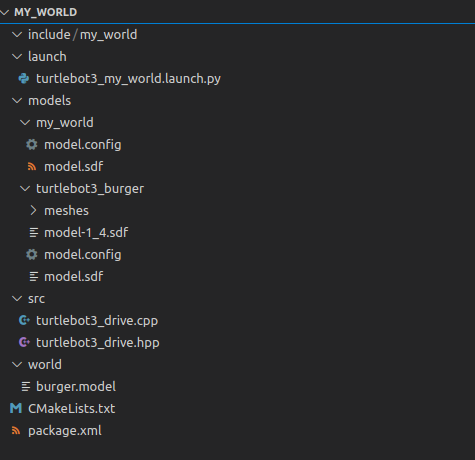

Os proporcionamos los siguientes ficheros:

- Drivers de turtlebot3: turtlebot3_drive.cpp y turtlebot3_drive.hpp. Sirven para construir el robot en simulación.


**turtlebot3_drive.cpp** > 


---



In [ ]:
// Copyright 2019 ROBOTIS CO., LTD.
//
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
//     http://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.
//
// Authors: Taehun Lim (Darby), Ryan Shim

#include "turtlebot3_drive.hpp"

#include <memory>

using namespace std::chrono_literals;

Turtlebot3Drive::Turtlebot3Drive()
: Node("turtlebot3_drive_node")
{
  /************************************************************
  ** Initialise variables
  ************************************************************/
  scan_data_[0] = 0.0;
  scan_data_[1] = 0.0;
  scan_data_[2] = 0.0;

  robot_pose_ = 0.0;
  prev_robot_pose_ = 0.0;

  /************************************************************
  ** Initialise ROS publishers and subscribers
  ************************************************************/
  auto qos = rclcpp::QoS(rclcpp::KeepLast(10));

  // Initialise publishers
  cmd_vel_pub_ = this->create_publisher<geometry_msgs::msg::Twist>("cmd_vel", qos);

  // Initialise subscribers
  scan_sub_ = this->create_subscription<sensor_msgs::msg::LaserScan>(
    "scan", \
    rclcpp::SensorDataQoS(), \
    std::bind(
      &Turtlebot3Drive::scan_callback, \
      this, \
      std::placeholders::_1));
  odom_sub_ = this->create_subscription<nav_msgs::msg::Odometry>(
    "odom", qos, std::bind(&Turtlebot3Drive::odom_callback, this, std::placeholders::_1));

  /************************************************************
  ** Initialise ROS timers
  ************************************************************/
  update_timer_ = this->create_wall_timer(10ms, std::bind(&Turtlebot3Drive::update_callback, this));

  RCLCPP_INFO(this->get_logger(), "Turtlebot3 simulation node has been initialised");
}

Turtlebot3Drive::~Turtlebot3Drive()
{
  RCLCPP_INFO(this->get_logger(), "Turtlebot3 simulation node has been terminated");
}

/********************************************************************************
** Callback functions for ROS subscribers
********************************************************************************/
void Turtlebot3Drive::odom_callback(const nav_msgs::msg::Odometry::SharedPtr msg)
{
  tf2::Quaternion q(
    msg->pose.pose.orientation.x,
    msg->pose.pose.orientation.y,
    msg->pose.pose.orientation.z,
    msg->pose.pose.orientation.w);
  tf2::Matrix3x3 m(q);
  double roll, pitch, yaw;
  m.getRPY(roll, pitch, yaw);

  robot_pose_ = yaw;
}

void Turtlebot3Drive::scan_callback(const sensor_msgs::msg::LaserScan::SharedPtr msg)
{
  uint16_t scan_angle[3] = {0, 30, 330};

  for (int num = 0; num < 3; num++) {
    if (std::isinf(msg->ranges.at(scan_angle[num]))) {
      scan_data_[num] = msg->range_max;
    } else {
      scan_data_[num] = msg->ranges.at(scan_angle[num]);
    }
  }
}

void Turtlebot3Drive::update_cmd_vel(double linear, double angular)
{
  geometry_msgs::msg::Twist cmd_vel;
  cmd_vel.linear.x = linear;
  cmd_vel.angular.z = angular;

  cmd_vel_pub_->publish(cmd_vel);
}

/********************************************************************************
** Update functions
********************************************************************************/
void Turtlebot3Drive::update_callback()
{
  static uint8_t turtlebot3_state_num = 0;
  double escape_range = 30.0 * DEG2RAD;
  double check_forward_dist = 0.7;
  double check_side_dist = 0.6;

  switch (turtlebot3_state_num) {
    case GET_TB3_DIRECTION:
      if (scan_data_[CENTER] > check_forward_dist) {
        if (scan_data_[LEFT] < check_side_dist) {
          prev_robot_pose_ = robot_pose_;
          turtlebot3_state_num = TB3_RIGHT_TURN;
        } else if (scan_data_[RIGHT] < check_side_dist) {
          prev_robot_pose_ = robot_pose_;
          turtlebot3_state_num = TB3_LEFT_TURN;
        } else {
          turtlebot3_state_num = TB3_DRIVE_FORWARD;
        }
      }

      if (scan_data_[CENTER] < check_forward_dist) {
        prev_robot_pose_ = robot_pose_;
        turtlebot3_state_num = TB3_RIGHT_TURN;
      }
      break;

    case TB3_DRIVE_FORWARD:
      update_cmd_vel(LINEAR_VELOCITY, 0.0);
      turtlebot3_state_num = GET_TB3_DIRECTION;
      break;

    case TB3_RIGHT_TURN:
      if (fabs(prev_robot_pose_ - robot_pose_) >= escape_range) {
        turtlebot3_state_num = GET_TB3_DIRECTION;
      } else {
        update_cmd_vel(0.0, -1 * ANGULAR_VELOCITY);
      }
      break;

    case TB3_LEFT_TURN:
      if (fabs(prev_robot_pose_ - robot_pose_) >= escape_range) {
        turtlebot3_state_num = GET_TB3_DIRECTION;
      } else {
        update_cmd_vel(0.0, ANGULAR_VELOCITY);
      }
      break;

    default:
      turtlebot3_state_num = GET_TB3_DIRECTION;
      break;
  }
}

/*******************************************************************************
** Main
*******************************************************************************/
int main(int argc, char ** argv)
{
  rclcpp::init(argc, argv);
  rclcpp::spin(std::make_shared<Turtlebot3Drive>());
  rclcpp::shutdown();

  return 0;
}


**turtlebot3_drive.hpp** > 


---

In [ ]:
// Copyright 2019 ROBOTIS CO., LTD.
//
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
//     http://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.
//
// Authors: Taehun Lim (Darby), Ryan Shim

#ifndef TURTLEBOT3_GAZEBO__TURTLEBOT3_DRIVE_HPP_
#define TURTLEBOT3_GAZEBO__TURTLEBOT3_DRIVE_HPP_

#include <geometry_msgs/msg/twist.hpp>
#include <nav_msgs/msg/odometry.hpp>
#include <rclcpp/rclcpp.hpp>
#include <sensor_msgs/msg/laser_scan.hpp>
#include <tf2/LinearMath/Matrix3x3.h>
#include <tf2/LinearMath/Quaternion.h>

#define DEG2RAD (M_PI / 180.0)
#define RAD2DEG (180.0 / M_PI)

#define CENTER 0
#define LEFT   1
#define RIGHT  2

#define LINEAR_VELOCITY  0.3
#define ANGULAR_VELOCITY 1.5

#define GET_TB3_DIRECTION 0
#define TB3_DRIVE_FORWARD 1
#define TB3_RIGHT_TURN    2
#define TB3_LEFT_TURN     3

class Turtlebot3Drive : public rclcpp::Node
{
public:
  Turtlebot3Drive();
  ~Turtlebot3Drive();

private:
  // ROS topic publishers
  rclcpp::Publisher<geometry_msgs::msg::Twist>::SharedPtr cmd_vel_pub_;

  // ROS topic subscribers
  rclcpp::Subscription<sensor_msgs::msg::LaserScan>::SharedPtr scan_sub_;
  rclcpp::Subscription<nav_msgs::msg::Odometry>::SharedPtr odom_sub_;

  // Variables
  double robot_pose_;
  double prev_robot_pose_;
  double scan_data_[3];

  // ROS timer
  rclcpp::TimerBase::SharedPtr update_timer_;

  // Function prototypes
  void update_callback();
  void update_cmd_vel(double linear, double angular);
  void scan_callback(const sensor_msgs::msg::LaserScan::SharedPtr msg);
  void odom_callback(const nav_msgs::msg::Odometry::SharedPtr msg);
};
#endif  // TURTLEBOT3_GAZEBO__TURTLEBOT3_DRIVE_HPP_


- Fichero base del mundo (buger.model): incluye el plano de tierra, la iluminación y la llamada a incluir el robot y vuestro entorno. A continuación se muestra cómo es este fichero: 

**burger.model** >


---



In [ ]:
<?xml version="1.0"?>
<sdf version="1.6">
  <world name="default">

    <include>
      <uri>model://ground_plane</uri>
    </include>

    <include>
      <uri>model://sun</uri>
    </include>

    <scene>
      <shadows>false</shadows>
    </scene>

    <gui fullscreen='0'>
      <camera name='user_camera'>
        <pose frame=''>0.319654 -0.235002 9.29441 0 1.5138 0.009599</pose>
        <view_controller>orbit</view_controller>
        <projection_type>perspective</projection_type>
      </camera>
    </gui>

    <physics type="ode">
      <real_time_update_rate>1000.0</real_time_update_rate>
      <max_step_size>0.001</max_step_size>
      <real_time_factor>1</real_time_factor>
      <ode>
        <solver>
          <type>quick</type>
          <iters>150</iters>
          <precon_iters>0</precon_iters>
          <sor>1.400000</sor>
          <use_dynamic_moi_rescaling>1</use_dynamic_moi_rescaling>
        </solver>
        <constraints>
          <cfm>0.00001</cfm>
          <erp>0.2</erp>
          <contact_max_correcting_vel>2000.000000</contact_max_correcting_vel>
          <contact_surface_layer>0.01000</contact_surface_layer>
        </constraints>
      </ode>
    </physics>

    <model name="my_world">
      <static>1</static>
      <include>
        <uri>model://my_world</uri>      </include>
    </model>
     
    <include>
      <pose>-2.0 -0.5 0.01 0.0 0.0 0.0</pose>
      <uri>model://turtlebot3_burger</uri>
    </include>

  </world>
</sdf>


- Los modelos del robot: turtlebot3_burger/model.sdf y model.config son los que detallan cómo es el robot para poder verlo en gazebo. Están incluidos también los modelos de las texturas, imágenes etc (directorio meshes)

- El fichero de lanzamiento. Se encarga de fijar todos los parámetros, lanzar gazebo y el nodo Robot_state_publisher (que es el que publica las transformadas del robot).

**turtlebot3_my_world.launch.py**>


---



In [ ]:
import os

from ament_index_python.packages import get_package_share_directory
from launch import LaunchDescription
from launch.actions import IncludeLaunchDescription
from launch.launch_description_sources import PythonLaunchDescriptionSource
from launch.substitutions import LaunchConfiguration
from launch_ros.substitutions import FindPackageShare

def generate_launch_description():
    pkg_share = FindPackageShare(package='my_world').find('my_world')
    gazebo_models_path = os.path.join(pkg_share, 'models')
    os.environ["GAZEBO_MODEL_PATH"] = gazebo_models_path
    use_sim_time = LaunchConfiguration('use_sim_time', default='true')
    world_file_name = 'burger.model'

    world = os.path.join(get_package_share_directory('my_world'),
                         'world', world_file_name)
    launch_file_dir = os.path.join(get_package_share_directory('turtlebot3_gazebo'), 'launch')
    pkg_gazebo_ros = get_package_share_directory('gazebo_ros')

    return LaunchDescription([
        IncludeLaunchDescription(
            PythonLaunchDescriptionSource(
                os.path.join(pkg_gazebo_ros, 'launch', 'gzserver.launch.py')
            ),
            launch_arguments={'world': world}.items(),
        ),

        IncludeLaunchDescription(
            PythonLaunchDescriptionSource(
                os.path.join(pkg_gazebo_ros, 'launch', 'gzclient.launch.py')
            ),
        ),

        IncludeLaunchDescription(
            PythonLaunchDescriptionSource([launch_file_dir, '/robot_state_publisher.launch.py']),
            launch_arguments={'use_sim_time': use_sim_time}.items(),
        ),

    ])


Para incluir vuestro modelo sdf, tenéis que hacer lo siguiente:

- Editar el modelo *.sdf creado y quitar la parte en la que incluye el plano de tierra (ground_plane) y la iluminación (sun). Llamar a este fichero model.sdf y grabarlo en el directorio models/my_world. Dejar sólo la descripción de vuestro modelo. Llamad al modelo my_world, el fichero deberá quedar de la siguiente manera (se ha quitado la parte de la descripción del modelo):


```
<?xml version="1.0" ?>
<sdf version='1.7'>
     <model name='my_world'>
     

     </model>
</sdf>
```



- Crear el fichero de configuración de vuestro entorno (model.config), que deberá contener lo siguiente (cambiando el autor por vuestros datos).




**model.config**>

---

In [ ]:
<?xml version="1.0"?>

<model>
  <name>my_world</name>
  <version>1.0</version>
  <sdf>model.sdf</sdf>  

  <author>
    <name>Asun</name>
    <email>asperez@eln.upv.es</email>
  </author>

  <description>
    Asun´s World with ROS symbol
  </description>
</model>


Por último tendréis que actualizar los ficheros CMakeLists.txt y package.xml.
A continuación podéis encontrar ambos ficheros.

**CMakeLists.txt** >


---



In [ ]:
################################################################################
# Set minimum required version of cmake, project name and compile options
################################################################################
cmake_minimum_required(VERSION 3.5)
project(my_world)

if(NOT CMAKE_CXX_STANDARD)
  set(CMAKE_CXX_STANDARD 14)
endif()

if(CMAKE_COMPILER_IS_GNUCXX OR CMAKE_CXX_COMPILER_ID MATCHES "Clang")
  add_compile_options(-Wall -Wextra -Wpedantic)
endif()

if(MSVC)
  add_compile_definitions(_USE_MATH_DEFINES)
endif()

################################################################################
# Find ament packages and libraries for ament and system dependencies
################################################################################
find_package(ament_cmake REQUIRED)
find_package(gazebo REQUIRED)
find_package(gazebo_ros_pkgs REQUIRED)
find_package(geometry_msgs REQUIRED)
find_package(nav_msgs REQUIRED)
find_package(rclcpp REQUIRED)
find_package(sensor_msgs REQUIRED)
find_package(tf2 REQUIRED)
find_package(turtlebot3_gazebo REQUIRED)

################################################################################
# Build
################################################################################
link_directories(
  ${GAZEBO_LIBRARY_DIRS}
)

include_directories(
  include
  ${GAZEBO_INCLUDE_DIRS}
)

set(dependencies
  "geometry_msgs"
  "nav_msgs"
  "rclcpp"
  "sensor_msgs"
  "tf2"
)

set(EXEC_NAME "turtlebot3_drive")

add_executable(${EXEC_NAME} src/turtlebot3_drive.cpp)
ament_target_dependencies(${EXEC_NAME} ${dependencies})

################################################################################
# Install
################################################################################
install(TARGETS ${EXEC_NAME}
  DESTINATION lib/${PROJECT_NAME}
)

install(DIRECTORY launch models world urdf
  DESTINATION share/${PROJECT_NAME}/
)

install(DIRECTORY include/
  DESTINATION include/
)

################################################################################
# Macro for ament package
################################################################################
ament_export_include_directories(include)
ament_export_dependencies(gazebo_ros_pkgs)
ament_export_dependencies(geometry_msgs)
ament_export_dependencies(nav_msgs)
ament_export_dependencies(rclcpp)
ament_export_dependencies(sensor_msgs)
ament_export_dependencies(tf2)
ament_package()

**package.xml>>**


---



In [ ]:
<?xml version="1.0"?>
<?xml-model href="http://download.ros.org/schema/package_format3.xsd" schematypens="http://www.w3.org/2001/XMLSchema"?>
<package format="3">
  <name>my_world</name>
  <version>0.0.0</version>
  <description>TODO: Package description</description>
  <maintainer email="asun@todo.todo">asun</maintainer>
  <license>TODO: License declaration</license>

  <buildtool_depend>ament_cmake</buildtool_depend>
  <depend>gazebo_ros_pkgs</depend>
  <depend>geometry_msgs</depend>
  <depend>nav_msgs</depend>
  <depend>rclcpp</depend>
  <depend>sensor_msgs</depend>
  <depend>tf2</depend>
  <exec_depend>turtlebot3_description</exec_depend>
  <test_depend>ament_lint_auto</test_depend>
  <test_depend>ament_lint_common</test_depend>

  <export>
    <build_type>ament_cmake</build_type>
  </export>
</package>


Para finalizar, compilar el paquete creado y simular.

In [ ]:
cd turtlebot3_ws
colcon build --packages-select my_world

Si se ha compilado correctamente podemos simular.

In [ ]:
ros2 launch my_world turtlebot3_my_world.launch.py

Comprobar que se lanza gazebo con vuestro entorno y que aparece el robot en él. 
Luego podéis comprobar que se han creado todos los nodos y topics del robot.

Debéis incluir la variable de entorno GAZEBO_MODEL_PATH con el path completo al directorio models.


In [ ]:
export GAZEBO_MODEL_PATH=$HOME/turtlebot3_ws/src/my_world/models:$GAZEBO_MODEL_PATH